# PeakVI: Analyzing scATACseq data

PeakVI is used for analyzing scATACseq data. This tutorial walks through how to read, set-up and train the model, accessing and visualizing the latent space, and differential accessibility. We use the 5kPBMC sample dataset from 10X but these steps can be easily adjusted for other datasets.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


In [2]:
import os
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pooch
import scanpy as sc
import scvi
import torch

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0


Last run with scvi-tools version: 1.3.1.post1


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(4, 4), frameon=False)
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor" : "w"}
%config InlineBackend.figure_format="retina"

## Download and preprocess data

First we need to download the sample data - we will use the `pooch` package to do this.

In [5]:
def download_data(save_path: str, fname: str = "atac_pbmc_5k") -> str:
    """Download the data files."""
    data_paths = pooch.retrieve(
        url="https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_pbmc_5k_nextgem/atac_pbmc_5k_nextgem_filtered_peak_bc_matrix.tar.gz",
        known_hash="78e536a1508108fa5bd3b411a7484809c011f3403800369b20db05bdbfeb2284",
        fname=fname,
        path=save_path,
        processor=pooch.Untar(),
        progressbar=True,
    )
    return str(Path(data_paths[0]).parent)

In [6]:
data_path = download_data(save_dir.name)

100%|███████████████████████████████████████| 114M/114M [00:00<00:00, 53.6GB/s]
Untarring contents of '/tmp/tmpiyurrnmn/atac_pbmc_5k' to '/tmp/tmpiyurrnmn/atac_pbmc_5k.untar'


PeakVI expects as input an AnnData object with a cell-by-region matrix. There are various pipelines that handle preprocessing of scATACseq to obtain this matrix from the sequencing data. If the data was generated by 10X genomics, this matrix is among the standard outputs of CellRanger. Other pipelines, like [SnapATAC](https://github.com/r3fang/SnapATAC/) and [ArchR](https://www.archrproject.com/bookdown/add-peak-matrix.html), also generate similar matrices.

In the case of 10X data, PeakVI has a special reader function `scvi.data.read_10x_atac` that reads the files and creates an AnnData object, demonstrated below. For conveniece, we also demonstrate how to initialize an AnnData object from scratch.

Throughout this tutorial, we use [sample scATACseq data from 10X of 5K PBMCs](https://support.10xgenomics.com/single-cell-atac/datasets/1.2.0/atac_pbmc_5k_nextgem).

In [7]:
adata = scvi.data.read_10x_atac(data_path)
adata

AnnData object with n_obs × n_vars = 4585 × 115554
    obs: 'batch_id'
    var: 'chr', 'start', 'end'

We can use Scanpy to handle, filter, and manipulate the data. In our case, we might want to filter out peaks that are rarely detected, to make the model train faster:

In [8]:
print("# regions before filtering:", adata.shape[-1])

# compute the threshold: 5% of the cells
min_cells = int(adata.shape[0] * 0.05)
# in-place filtering of regions
sc.pp.filter_genes(adata, min_cells=min_cells)

print("# regions after filtering:", adata.shape[-1])

# regions before filtering: 115554
# regions after filtering: 33142


## Set up, train, save, and load the model

We can now set up the AnnData object with PeakVI, which will ensure everything the model needs is in place for training.

This is also the stage where we can condition the model on additional covariates, which encourages the model to remove the impact of those covariates from the learned latent space. Our sample data is a single batch, so we won't demonstrate this directly, but it can be done simply by setting the `batch_key` argument to the annotation to be used as a batch covariate (must be a valid key in `adata.obs`) .

In [9]:
scvi.model.PEAKVI.setup_anndata(adata)

We can now create a PeakVI model object and train it!

```{important}
The default `max_epochs` is set to `500`, but in practice PeakVI stops early once the model converges (we quantify convergence with the model's validation reconstruction loss). This is especially the case for larger datasets, which require fewer training epochs to converge since each epoch lets the model view more data.

This means that the estimated training runtime is usually an overestimate of the actual runtime. For the data used in this tutorial, it typically converges with around half of `max_epochs`!
```

In [10]:
model = scvi.model.PEAKVI(adata)
model.train()

<ipython-input-10-afe809d3088a>:2: DeprecationWarning: `save_best` is deprecated in v1.2 and will be removed in v1.3. Please use `enable_checkpointing` instead. See https://github.com/scverse/scvi-tools/issues/2568 for more details.
  model.train()
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 13004.480. Signaling Trainer to stop.


Since training a model can take a while, we recommend saving the trained model after training, just in case.

In [11]:
model_dir = os.path.join(save_dir.name, "peakvi_pbmc")
model.save(model_dir, overwrite=True)

We can then load the model later, which require providing an AnnData object that is structured similarly to the one used for training (or, in most cases, the same one):

In [12]:
model = scvi.model.PEAKVI.load(model_dir, adata=adata)

INFO     File /tmp/tmpiyurrnmn/peakvi_pbmc/model.pt already downloaded                                             


## Visualizing and analyzing the latent space

We can now use the trained model to visualize, cluster, and analyze the data. We first extract the latent representation from the model, and save it back into our AnnData object:

In [13]:
PEAKVI_LATENT_KEY = "X_peakvi"

latent = model.get_latent_representation()
adata.obsm[PEAKVI_LATENT_KEY] = latent
latent.shape

(4585, 13)

We can now use Scanpy to cluster and visualize our latent space:

In [14]:
PEAKVI_CLUSTERS_KEY = "clusters_peakvi"

# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(adata, use_rep=PEAKVI_LATENT_KEY)
# compute the umap
sc.tl.umap(adata, min_dist=0.2)
# cluster the space (we use a lower resolution to get fewer clusters than the default)
sc.tl.leiden(adata, key_added=PEAKVI_CLUSTERS_KEY, resolution=0.2)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7acc203cd080>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/scipy.libs/libscipy_openblas-68440149.

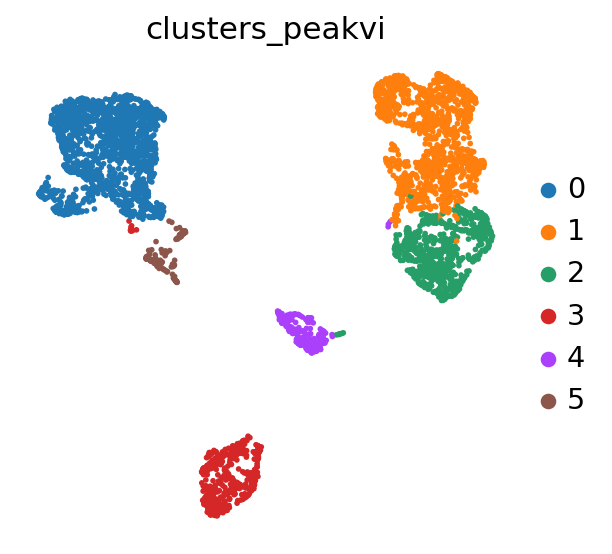

In [15]:
sc.pl.umap(adata, color=PEAKVI_CLUSTERS_KEY)

## Differential accessibility

Finally, we can use PeakVI to identify regions that are differentially accessible. There are many different ways to run this analysis, but the simplest is comparing one cluster against all others, or comparing two clusters to each other. In the first case we'll be looking for marker-regions, so we'll mostly want a one-sided test (the significant regions will only be the ones preferentially accessible in our target cluster). In the second case we'll use a two-sided test to find regions that are differentially accessible, regardless of direction.

We demonstrate both of these next, and do this in two different ways: (1) more convenient but less flexible: using an existing factor to group the cells, and then comparing groups. (2) more flexible: using cell indices directly.

```{important}
If the data includes multiple batches, we encourage setting `batch_correction=True` so the model will sample from multiple batches when computing the differential signal. We do this below despite the data only having a single batch, as a demonstration.
```

In [18]:
# (1.1) using a known factor to compare two clusters
## two-sided is True by default, but included here for emphasis
da_res11 = model.differential_accessibility(groupby=PEAKVI_CLUSTERS_KEY, group1="3", group2="0")

# (1.2) using a known factor to compare a cluster against all other clusters
## if we only provide group1, group2 is all other cells by default
da_res12 = model.differential_accessibility(groupby=PEAKVI_CLUSTERS_KEY, group1="3")

# (2.1) using indices to compare two clusters
## we can use boolean masks or integer indices for the `idx1` and `idx2` arguments
da_res21 = model.differential_accessibility(
    idx1=adata.obs[PEAKVI_CLUSTERS_KEY] == "3",
    idx2=adata.obs[PEAKVI_CLUSTERS_KEY] == "0",
)
# (2.2) using indices to compare a cluster against all other clusters
## if we don't provide idx2, it uses all other cells as the contrast
da_res22 = model.differential_accessibility(
    idx1=np.where(adata.obs[PEAKVI_CLUSTERS_KEY] == "3"),
)

da_res22.head()

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,prob_da,is_da_fdr,bayes_factor,effect_size,emp_effect,est_prob1,est_prob2,emp_prob1,emp_prob2
chr10:126289468-126291985,1.0,True,18.420681,-0.882701,-0.485640,0.919949,0.037248,0.505495,0.019855
chr19:17886105-17887874,1.0,True,18.420681,-0.615924,-0.323505,0.659339,0.043415,0.345055,0.021550
chr2:60577910-60581495,1.0,True,18.420681,-0.921378,-0.521755,0.950129,0.028751,0.538462,0.016707
chr1:110926104-110928161,1.0,True,18.420681,-0.712230,-0.383591,0.758555,0.046325,0.406593,0.023002
chr12:92566079-92567078,1.0,True,18.420681,-0.815181,-0.433824,0.844579,0.029398,0.448352,0.014528


Note that `da_res11` and `da_res21` are equivalent, as are `da_res12` and `da_res22`.
The return value is a pandas DataFrame with the differential results and basic properties of the comparison:

`prob_da` in our case is the probability of cells from cluster 0 being more than 0.05 (the default minimal effect) more accessible than cells from the rest of the data.

`is_da_fdr` is a conservative classification (True/False) of whether a region is differential accessible. This is one way to threshold the results.

`bayes_factor` is a statistical significance score. It doesn't have a commonly acceptable threshold (e.g 0.05 for p-values), bu we demonstrate below that it's well calibrated to the effect size.

`effect_size` is the effect size, calculated as `est_prob1 - est_prob2`.

`emp_effect` is the empirical effect size, calculated as `emp_prob1 - emp_prob2`.

`est_prob{1,2}` are the estimated probabilities of accessibility in group1 and group2.

`emp_prob{1,2}` are the empirical probabilities of detection (how many cells in group X was the region detected in).

We can make sure the probability of DA is well calibrated, and look at the regions that are identified as differentially accessible:

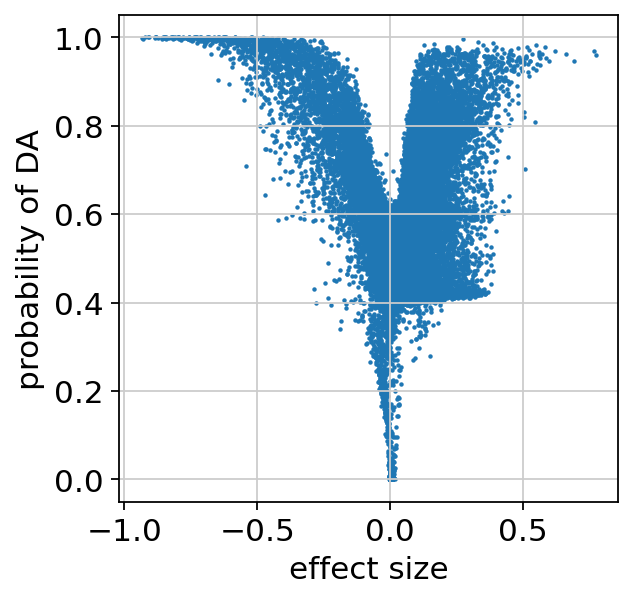

,prob_da,is_da_fdr,bayes_factor,effect_size,emp_effect,est_prob1,est_prob2,emp_prob1,emp_prob2
chr2:232535623-232538141,1.0,True,18.420681,-0.884773,-0.563122,0.932184,0.047411,0.591209,0.028087
chr16:67550946-67553518,1.0,True,18.420681,-0.731375,-0.376532,0.779920,0.048546,0.402198,0.025666
chr4:115519248-115520882,1.0,True,18.420681,-0.735972,-0.380611,0.771040,0.035068,0.397802,0.017191
chr1:110926104-110928161,1.0,True,18.420681,-0.712230,-0.383591,0.758555,0.046325,0.406593,0.023002
chr12:92566079-92567078,1.0,True,18.420681,-0.815181,-0.433824,0.844579,0.029398,0.448352,0.014528
chr2:60577910-60581495,1.0,True,18.420681,-0.921378,-0.521755,0.950129,0.028751,0.538462,0.016707
chr19:17886105-17887874,1.0,True,18.420681,-0.615924,-0.323505,0.659339,0.043415,0.345055,0.021550
chr5:150503270-150506342,1.0,True,18.420681,-0.688972,-0.390892,0.936402,0.247429,0.525275,0.134383
chr10:126289468-126291985,1.0,True,18.420681,-0.882701,-0.485640,0.919949,0.037248,0.505495,0.019855
chr3:122294823-122297353,1.0,True,18.420681,-0.728473,-0.417974,0.861869,0.133396,0.492308,0.074334


In [29]:
plt.scatter(da_res22.effect_size, da_res22.prob_da, s=1)
plt.xlabel("effect size")
plt.ylabel("probability of DA")
plt.show()

da_res22.loc[da_res22.is_da_fdr].sort_values("prob_da", ascending=False).head(10)

We can now examine these regions to understand what is happening in the data, using various different annotation and enrichment methods. For instance, `chr11:60222766-60223569`, one of the regions preferentially accessible in cluster 0, is the promoter region of [`MS4A1`](https://www.genecards.org/cgi-bin/carddisp.pl?gene=MS4A1), also known as `CD20`, a known B-cell surface marker, indicating that cluster 0 are probably B-cells.